# The setup and functions

In [45]:
# import modules
from numba import jit
import numpy as np
import scipy as sp
from scipy.optimize import root_scalar
from scipy.stats import norm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib

"""-------------------------------------------------------------------------"""
"""The functions to set up the plasma profile"""
"""-------------------------------------------------------------------------"""

def jet(angle, a, R0, delta, kappa):
    R = R0 + a*np.cos(angle + delta*np.sin(angle))
    z = kappa*a*np.sin(angle)

    return R, z

def inverse(R, z, R0, delta, kappa):
    
    def f(x, R=1, z=1, R0=1, delta=1, kappa=1, neg_side=False):
        theta = np.arcsin(z/(kappa*x))
        if neg_side:
            theta = np.pi - theta

        return x*np.cos(theta + delta*z/(kappa*x)) -R +R0

    try:
        a = root_scalar(f, args=(R, z, R0, delta, kappa), bracket=[abs(z/kappa)+1e-13, 2], method='brentq').root
        #The extra 1e-13 is to avoid the root finding algorithm to get stuck, as arcsin needs an argument between -1 and 1
        return a, np.arcsin(z/(kappa*a))
    
    except ValueError:
        try:
            #print('Were on the negative side')
            a = root_scalar(f, args=(R, z, R0, delta, kappa, True), bracket=[abs(z/kappa)+1e-13, 2], method='brentq').root
            return a, np.pi - np.arcsin(z/(kappa*a))
    
        except ValueError:
            return 2, np.pi

def jet_profile(a, theta, amplitude=.25, mode_num=4, phase=0.):
    if a>1:
        #This is to avoid the plasma extending beyond the last closed flux surface
        return 0 
    
    elif a< .8:
        #Inside, the density follows the flux surfaces to 1st order
        return np.sqrt(1-a) 
    
    else:
        #between around a=.8 to a=1, we add a perturbation, gaussian in a, sinusoidal in theta
        argument = (mode_num*theta + phase/mode_num if mode_num!=0 else 0)
        return np.sqrt(1-a) + amplitude * np.cos(argument)* np.exp(-((a-.9)/.04)**2) 
    

def make_density(R, z, R0, ne_peak, delta, kappa, profile=jet_profile, amplitude=.25, mode_num=4, phase=0.):

    grid = np.zeros((len(z), len(R)))
    outer_contour_R, outer_contour_z = jet(np.linspace(0, 2*np.pi, 200), 1, R0, delta, kappa)
    RM, Rm, zM, zm = np.amax(outer_contour_R), np.amin(outer_contour_R), np.amax(outer_contour_z), np.amin(outer_contour_z)

    

    for i, R_val in enumerate(R):
        for j, z_val in enumerate(z):
            if R_val > RM or R_val < Rm or z_val > zM or z_val < zm:
                continue
            else:
                contour_value, theta = inverse(R_val, z_val, R0, delta, kappa)
                grid[j, i] = ne_peak *profile(contour_value, theta, amplitude, mode_num, phase)
                # use grid[i, j] to rotate and send from HFS
                # use grid[-i, j] to rotate and send from LFS

    return grid

"""-------------------------------------------------------------------------"""
"""The functions to set up the simulation"""
"""-------------------------------------------------------------------------"""

@jit
def make_antenna_profile(npt_y, xs, w0, source, bb):
    
    for y in range(2, npt_y - 1, 2):
        
        aux = (npt_y / 2 - y) / w0
        
        aux1 = 0.75 * np.exp(-aux * aux) * 20 # gaussian envelope
        
        # excite Bz component (odd - odd)
        bb[int(xs + 1), y + 1] += 2 * source * aux1

"""--------------------------------------"""

@jit
def make_B0(npt_x, npt_y, cntrl_para, b0):
    for x in range(0, npt_x - 1, 2):
        for y in range(0, npt_y - 1, 2):
            b0[x + 1, y + 1] = cntrl_para # B0z

"""--------------------------------------"""

@jit
def absorbers(depth, npt_x, npt_y, ee, bb, jj, b0): # depth -> depth of the absorbing region
    # absorbers on the left boundary
    for x in range(2, depth + 1):
        for y in range(2, npt_y - 1):
            
            ee[x, y] *= 0.985
            bb[x, y] *= 0.985
            jj[x, y] *= 0.985
            b0[x, y] *= 0.985
            
    # absorbers on the right boundary
    for x in range(npt_x - depth + 1, npt_x - 1):
        for y in range(2, npt_y - 1):
            
            ee[x, y] *= 0.98
            bb[x, y] *= 0.98
            jj[x, y] *= 0.98
            b0[x, y] *= 0.98
            
    # absorbers on top/bottom boundaries
    for x in range(2, npt_x - 1):
        for y in range(2, npt_y + 1):
            
            if (y < depth) or (y > npt_y - depth):
                ee[x, y] *= 0.962
                bb[x, y] *= 0.962
                jj[x, y] *= 0.962
                b0[x, y] *= 0.962

"""--------------------------------------"""

@jit
def update_equations(npt_x, npt_y, dt, aux_jp,
                     ee, bb, jj, b0, epsilon_r):
    
    for x in range(2, npt_x - 1, 2):
        for y in range(2, npt_y - 1, 2):
            
            # Jx component (odd - even)
            jj[x + 1, y] += dt * (
                4 * np.pi**2 * ee[x + 1, y] * aux_jp[x, y]
                - 4 * np.pi**2 * jj[x, y + 1] * b0[x + 1, y + 1] # + Jy * B0z
            ) 
            
            # Jy component (even - odd)
            jj[x, y + 1] += dt * (
                4 * np.pi**2 * ee[x, y + 1] * aux_jp[x, y]
                - 4 * np.pi**2 * (- jj[x + 1, y] * b0[x + 1, y + 1]) # - Jx * B0z
            )
                                 
            
            
            # Bz component (odd - odd)
            # dBz/dt = dEx/dy - dEy/dx - Jx
            bb[x + 1, y + 1] += - 0.5 * ((ee[x + 2, y + 1] - ee[x, y + 1]) 
                                         - (ee[x + 1, y + 2] - ee[x + 1, y])) / epsilon_r[x, y]
            
            
            # Ex component (odd - even)
            # dEx/dt = dBz/dy
            ee[x + 1, y] += 0.5 * (bb[x + 1, y + 1] - bb[x + 1, y - 1]) - dt * jj[x + 1, y]
            
            
                
            # Ey component (even - odd)
            # dEy/dt = -dBz/dx - Jy
            ee[x, y + 1] += - 0.5 * (bb[x + 1, y + 1] - bb[x - 1, y + 1]) - dt * jj[x, y + 1]           


"""--------------------------------------"""

@jit
def power_receving_antenna(npt_y, xr, ee, dens):
    
    for y in range(2, npt_y - 1, 2):
        
        # calculate power as
        # sqrt(Ex^2 + Ey^2)
        aux = np.sqrt(ee[int(xr + 1), y] * ee[int(xr + 1), y] + 
                     ee[int(xr), y + 1] * ee[int(xr), y + 1])
        
        # time average
        dens[y] = dens[y] * 0.9995 + 0.0005 * aux * aux

"""--------------------------------------"""

@jit
def poynting_vector_Py(npt_y, xr, ee, bb, dens):
    
    for y in range(2, npt_y - 1, 2):
        
        # calculate Poynting vector Py
        # Py = - Ex * Hz + Ez * Hx
        aux = - ee[int(xr + 1), y] * bb[int(xr + 1), y + 1]
        
        # time average
        dens[y] = dens[y] * 0.9995 + 0.0005 * aux * aux


In [46]:
def run_simulation(foldername, scale=scale, cntrl_para=cntrl_para, ne_peak=ne_peak, R0=R0, delta=delta, kappa=kappa, amplitude=amplitude, mode_num=mode_num, phase=phase):


    # number of points in the horizontal direction
    Nx = 640 * scale 

    # number of points in the vertical direction
    Ny = 640 * scale

    # grid points per period
    n_period = 16 * scale

    # simulation time steps
    t_end = 100 * n_period

    # time step to start recording power at receiving antenna plane
    t_power = 20 * n_period

    # probing frequency in GHz
    fo = 208 # GHz

    # wavelength in meters
    lambda_0 = sp.constants.c / (fo * 10**9)

    # wavelength in mm
    wavelength = lambda_0 * 10**3

    # beam waist 
    w0 = 2. / wavelength * n_period

    # length step in fdtd code
    dx = 1 / (n_period / 2)

    # effective stime step in fdtd code
    dt = 1 / (2 * (n_period / 2))

    # time step for antenna excitation
    dt_1 = 1 / n_period


    # define fields
    EE = np.zeros((Nx + 4, Ny + 4)) # electric field
    BB = np.zeros((Nx + 4, Ny + 4)) # magnetic field
    JJ = np.zeros((Nx + 4, Ny + 4)) # current density
    B0 = np.zeros((Nx + 4, Ny + 4)) # background magnetic field 
    EPSILON_R = np.ones((Nx + 4, Ny + 4)) # relative permittivity for quartz tube


    # array to monitor power at receiving antenna plane
    dens = np.zeros(Ny + 4)

    # quartz tube outer radius
    R_outer = ((30 / 2) / wavelength) * n_period

    # emitting antenna position
    xs = np.floor(Nx / 2 - R_outer - n_period)

    # receiving antenna position
    xr = np.ceil(Nx / 2 + R_outer + n_period)

    # ensure antennas are located at even grid points
    if xs % 2 != 0:
        xs -= 1
        
    if xr % 2 != 0:
        xr += 1


    """-------------------------------------------------------------------------"""
    """Calculate the plasma profile"""
    """-------------------------------------------------------------------------"""

    R = np.linspace(0, 6, 40*n_period)
    z = np.linspace(-3, 3, 40*n_period)

    aux_jp = make_density(R,z, R0, ne_peak, delta, kappa, jet_profile, amplitude, mode_num, phase)

    make_B0(Nx, Ny, cntrl_para, B0)

    # omega_t = omega * t
    omega_t = 0

    """-------------------------------------------------------------------------"""
    """Main loop"""
    """-------------------------------------------------------------------------"""

    for t_int in range(0, t_end + 1):
        
        aux = t_int / 140
        
        t_rise = 1 - np.exp(-aux * aux)
        
        omega_t += 2 * np.pi * dt_1
        
        if (omega_t > 2 * np.pi):
            omega_t -= 2 * np.pi
        
        source = np.sin(omega_t) * t_rise / 1.4
        
        # excite magnetic field
        make_antenna_profile(Ny, xs, w0, source, BB)    
                
        # apply the absorbing boundary conditions
        absorbers(int(3 * n_period), Nx, Ny, EE, BB, JJ, B0)
        
        # update equations
        update_equations(Nx, Ny, dt, aux_jp, 
                        EE, BB, JJ, B0, EPSILON_R)
        
        # monitor power
        if t_int > t_power:
            
            power_receving_antenna(Ny, xr, EE, dens)
            #poynting_vector_Py(Ny, xr, EE, BB, dens)

    np.savetxt(f'02_files/{foldername}/{ne_peak:.3f}_{R0:.3f}_{delta:.3f}_{kappa:.3f}_{amplitude:.3f}_{mode_num:.3f}_{phase:.3f}.txt', dens[3*n_period:-3*n_period:2])
    return


In [47]:
def getRand(size, mean, stdev, lower, upper):
    randoms = []

    while len(randoms) < size:
        a = np.random.normal(mean, stdev)
        if (a > lower and a < upper):
            randoms.append(a)

    return np.array(randoms)


def createPairs(size, params, names, types):
    pairs = []

    for i, name in enumerate(names):
        if types[i]=='gaussian':
            par = params[i]
            randoms = getRand(size, par[0], par[1], par[2], par[3])
            pairs.append(randoms)
        elif types[i]=='uniform':
            par = params[i]
            randoms = np.random.uniform(par[0], par[1], size)
            pairs.append(randoms)
        elif types[i]=='integer':
            par = params[i]
            randoms = np.random.randint(par[0], par[1]+1, size)
            pairs.append(randoms)

    couples = np.stack(pairs, axis=1)

    #pairPlot(couples, params, names)

    return couples


def pairPlot(outputs, params, names):
    n_outputs = outputs.shape[1]
    fig, ax = plt.subplots(n_outputs, n_outputs, figsize=(8, 8))

    plt.set_cmap('cividis')
    for i in range(n_outputs):
        for j in range(n_outputs):

            ax[i, j].spines.right.set_visible(False)
            ax[i, j].spines.top.set_visible(False)
            if i == j:
                x = np.linspace(
                    np.amin(outputs[:, j]), np.amax(outputs[:, j]), 100)
                distr = norm.pdf(x, params[j, 0], params[j, 1])

                ax[i, j].plot(x, distr, linewidth=1.2, c='blue')
                ax[i, j].set_ylim(0)
                ax[i, j].vlines(
                    [x[0], x[-1]], ymin=0, ymax=[distr[0], distr[-1]], color='blue', linewidth=1.2)
                ax[i, j].fill_between(x, distr, alpha=0.15, color='blue')
                ax[i, j].set_ylabel('')
                ax[i, j].tick_params(left=False, labelleft=False, labelsize=20)

            else:
                ax[i, j].scatter(outputs[:, j], outputs[:, i], s=0.6, c='blue')
                ax[i, j].tick_params(labelsize=20)

        ax[i, 0].set_ylabel(names[i], fontsize=32)
    for j in range(n_outputs):
        ax[-1, j].set_xlabel(names[j], fontsize=32)
    plt.savefig("02_files/00_pairplot_{}.pdf".format(outputs.shape[0]))
    plt.show()
    return



# Case 1, the general profile

In [48]:

"""-------------------------------------------------------------------------"""
"""Simulation specifics"""
"""-------------------------------------------------------------------------"""

# input parameters
scale = 1 # variable to scale the code

# background magnetic field strength
cntrl_para = 0.0 #Set to 0 for O-mode

#for the JET-like profile

#ne_peak = .4        # peak plasma density (normalised to cutoff density)

#R0 = 3.              # centre of the plasma profile
#delta = 1       # triangularity
#kappa = 1.5        # elongation

amplitude = .0    # amplitude of the plasma perturbation
mode_num = 0.        # mode number of the plasma perturbation
phase = 0.        # phase of the plasma perturbation


In [49]:
folder = 'dataset_1'
params = np.array([[0.4, 0.25, 0.1, .7], [3, .4, 2.6, 3.4],
                  [.5, .3, 0, 1], [1.3, .3, 1, 1.7]])
names = (r"$n_{e,peak}$", r"$R0$", r"$\delta$", r"$\kappa$")
types = ('gaussian', 'gaussian', 'gaussian', 'gaussian')


couples = createPairs(6, params, names, types)

np.savetxt(f"02_files/00_{folder}_parameter_data_{couples.shape[0]}.csv", couples, fmt='%.4e', delimiter=",")


In [50]:
for i, couple in enumerate(couples):
    
    run_simulation(folder, scale, cntrl_para, couple[0], couple[1], couple[2], couple[3])
    if i % 1 == 0:
        print("Simulation {} of {} completed".format(i+1, couples.shape[0]))


Simulation 1 of 6 completed
Simulation 2 of 6 completed
Simulation 3 of 6 completed
Simulation 4 of 6 completed
Simulation 5 of 6 completed
Simulation 6 of 6 completed


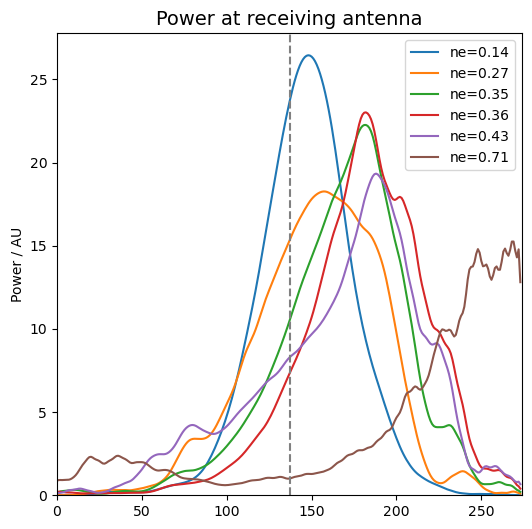

In [51]:
import os
gs = gridspec.GridSpec(1, 1)

plt.figure(figsize = (6, 6), dpi = 100)
ax1 = plt.subplot(gs[0, 0])

for i, filename in enumerate(os.listdir(f'02_files/{folder}/')):
    dens = np.loadtxt(f'02_files/{folder}/' + filename)
    ax1.plot(dens, label=f'ne={filename[0:4]}')

ax1.set_title('Power at receiving antenna', fontsize = 14)
ax1.axvline(x = len(dens)/2, color = 'grey', linestyle = '--')
ax1.set_ylabel('Power / AU')
ax1.set_ylim(0)
ax1.set_xlim(0, len(dens))
ax1.legend()

# Case 2, ELMs

In [52]:

"""-------------------------------------------------------------------------"""
"""Simulation specifics"""
"""-------------------------------------------------------------------------"""

# input parameters
scale_2 = 1 # variable to scale the code

# background magnetic field strength
cntrl_para_2 = 0.0 #Set to 0 for O-mode

#for the JET-like profile

ne_peak = .4        # peak plasma density (normalised to cutoff density)

R0 = 3.15              # centre of the plasma profile
delta = .4       # triangularity
kappa = 1.5        # elongation

#amplitude = .0    # amplitude of the plasma perturbation
#mode_num = 0.        # mode number of the plasma perturbation
#phase = 0.        # phase of the plasma perturbation


In [53]:
folder_2 = 'dataset_2'
params_2 = np.array([[0.18, 0.15, .0, .3], [0, 4],
                  [0, 6.28]])
names_2 = ("amplitude", "mode_num", "phase")
types_2 = ('gaussian', 'integer', 'uniform')


couples_2 = createPairs(6, params_2, names_2, types_2)

np.savetxt(f"02_files/00_{folder_2}_parameter_data_{couples_2.shape[0]}.csv", couples_2, fmt='%.4e', delimiter=",")


C:\Users\ewout\AppData\Local\Temp\ipykernel_12436\2086642281.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  params_2 = np.array([[0.18, 0.15, .0, .3], [0, 4],


In [54]:
for i, couple in enumerate(couples_2):
    
    run_simulation(folder_2, scale_2, cntrl_para_2, ne_peak, R0, delta, kappa, couple[0], couple[1], couple[2])
    if i % 1 == 0:
        print("Simulation {} of {} completed".format(i+1, couples_2.shape[0]))

Simulation 1 of 6 completed
Simulation 2 of 6 completed
Simulation 3 of 6 completed
Simulation 4 of 6 completed
Simulation 5 of 6 completed
Simulation 6 of 6 completed


In [59]:
run_simulation('control_2', scale_2, cntrl_para_2, ne_peak, R0, delta, kappa, 0, 0, 0)

(0.0, 13.200973930376225)

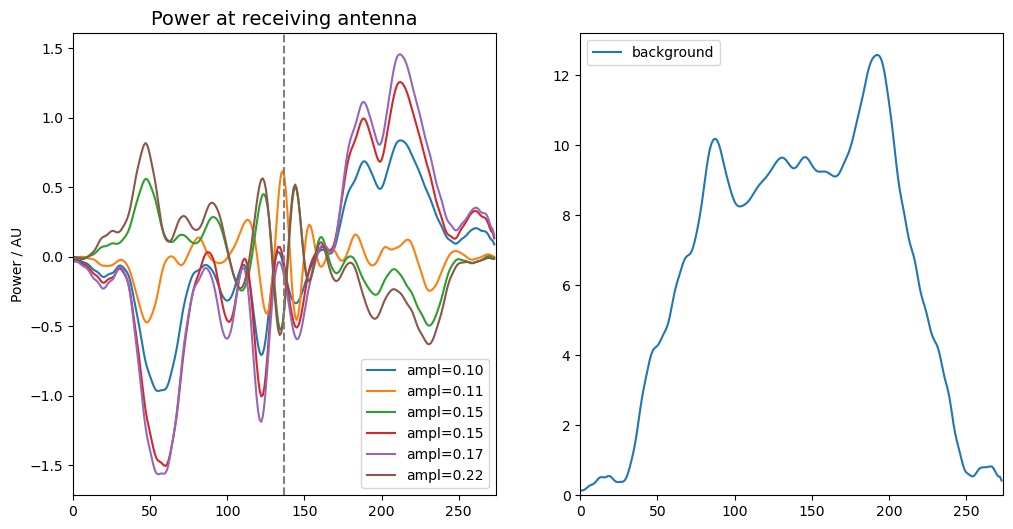

In [65]:
import os
gs = gridspec.GridSpec(1, 2)

plt.figure(figsize = (12, 6), dpi = 100)
ax1 = plt.subplot(gs[0, 0])
dens_background = np.loadtxt(f'02_files/control_2/0.40_3.15_0.40_1.50_0.00_0.00_0.00.txt')

for i, filename in enumerate(os.listdir(f'02_files/{folder_2}/')):
    dens = np.loadtxt(f'02_files/{folder_2}/' + filename)
    ax1.plot(dens - dens_background, label=f'ampl={filename[20:24]}')

ax1.set_title('Power at receiving antenna', fontsize = 14)
ax1.axvline(x = len(dens)/2, color = 'grey', linestyle = '--')
ax1.set_ylabel('Power / AU')
#ax1.set_ylim(0)
ax1.set_xlim(0, len(dens))
ax1.legend()

ax2 = plt.subplot(gs[0, 1])
ax2.plot(dens_background, label='background')
ax2.legend()
ax2.set_xlim(0, len(dens))
ax2.set_ylim(0)